In [1]:
library(DESeq2)
library(Seurat)
library(harmony)
library(ggplot2)
library(CPlink)
library(CelliD)

载入需要的程辑包：S4Vectors

载入需要的程辑包：stats4

载入需要的程辑包：BiocGenerics


载入程辑包：‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



载入程辑包：‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


载入需要的程辑包：IRanges

载入需要的程辑包：GenomicRanges

载入需要的程辑包：GenomeInfoDb

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘MatrixGenerics’


The following objects are m

In [2]:
setwd("~/CPlinkPrior/data/")

In [3]:
sc_count <- readRDS("sc_count.rds")
sc_meta <- readRDS("sc_meta.rds")
PriSigs <- read.csv("SenescenceGenes.csv")

In [4]:
sc_seurat <- runRNA(sc_count, sc_meta, min.cells = 3, batch_correct = TRUE, batch_var = "donor_id")

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 5815650)”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [5]:
DGs_mtx <- data.frame(markers=unique(PriSigs[,1]), logFC=1)
rownames(DGs_mtx) <- unique(PriSigs[,1])

data_matrix <- as.matrix(GetAssayData(sc_seurat, slot = "data"))
nn <- sc_seurat@graphs$RNA_snn

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 28.3 GiB”


In [6]:
CPlink_out_mtx <- runCPlinkPrior(data_matrix, DGs_mtx, snn = nn, seed_ratio = NULL, restart_prob = NULL, 
                            sim_methods ="cosine", SigThreshold = 0.05)

Starting CPlinkPrior pipeline

Running MCA on signatures

Computing Fuzzy Matrix



1.275 sec elapsed


Computing SVD



15.812 sec elapsed


Computing Coordinates



0.459 sec elapsed


Computing feature-to-cell association matrix

Calculating initial phenotype association scores

Warning message in runCellScores(cell_feature_mtx, DEGs_mtx, up_weight = up_weight, :
“No downregulated markers found”
Restart Probability: 0.05; Seeds Ratio: 0.99

Computing empirical p-values and assign CPlink+ / CPlink- labels

CPlinkPrior run completed successfully



In [7]:
sc_seurat <- sc_seurat
sc_seurat@meta.data <- cbind(sc_seurat@meta.data, 
                                  cbind(CPlink_out_mtx[[1]], CPlink_out_mtx[[2]])[rownames(sc_seurat@meta.data),])

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


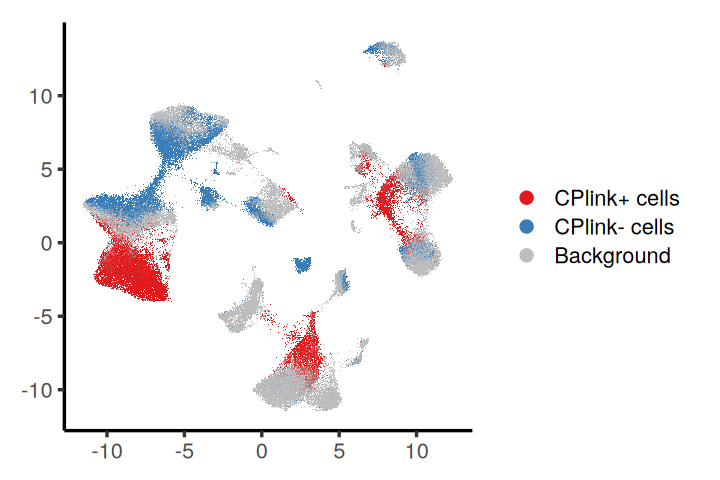

In [8]:
options(repr.plot.width=6, repr.plot.height=4)
DimPlot(sc_seurat,reduction="umap",group.by=c("cellLabels"), 
               #label = F, raster=FALSE,
       order=c("CPlink+ cells", "CPlink- cells", "Background"),
        cols = c("#e11a1d", "#387db8", "grey" ))+labs(title = NULL)+
scale_colour_discrete(breaks=c("CPlink+ cells", "CPlink- cells", "Background"), type= c("grey", "#387db8", "#e11a1d"))+
     theme_classic(base_size = 16, base_rect_size = 1.5)+
     theme(#panel.grid = element_blank(), axis.ticks = element_blank(),
         #  legend.position = c(0.8,0.1),
          # panel.border = element_blank(),
          # axis.text = element_blank(),
           axis.title = element_blank(),
           plot.title = element_text( colour = "black"),
          legend.text = element_text( colour = "black")
          )

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


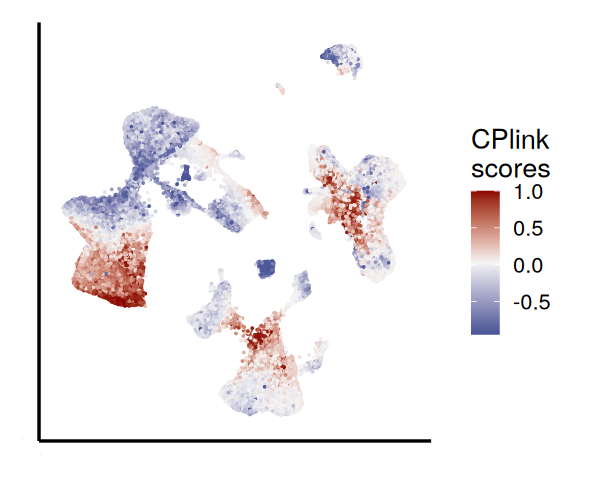

In [9]:
options(repr.plot.width=5, repr.plot.height=4)
FeaturePlot(sc_seurat,
            features = "CPlinkScore", raster=FALSE, label = FALSE) +
            scale_color_gradientn(colors = c("#475496", "#F5F5F5", "darkred"))+
labs(title = NULL)+
     theme_classic(base_size = 16, base_rect_size = 1.5)+
     theme(panel.grid = element_blank(), axis.ticks = element_blank(),legend.position = "right",
           panel.border = element_blank(),
           axis.text = element_blank(),
           axis.title = element_text(size = 0, hjust = 0, colour = "black"), 
           plot.title = element_text( hjust=0.5, colour = "black"),
          legend.text = element_text(colour = "black")
          ) +
  guides(color = guide_colorbar(title = "CPlink \nscores"))

In [10]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/CPlinkTest/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] CelliD_1.10.1               SingleCellExperiment_1.22.0
 [3] CPlink_0.1.0                ggplot2_3.5.1              
 [5] harmony_0.1.1               Rcpp_1.0.13                
 [7] SeuratObject_5.0.2       